In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv(f'/content/drive/MyDrive/hyderabad.csv')

In [4]:
df.head()


,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2009-01-01 00:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,...,21,9,0,83,0.0,1013,16,10,150,6
1,2009-01-01 01:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,...,20,9,0,85,0.0,1013,16,10,148,5
2,2009-01-01 02:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,...,20,8,0,86,0.0,1013,15,10,147,5
3,2009-01-01 03:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,...,19,8,0,88,0.0,1013,15,10,145,5
4,2009-01-01 04:00:00,28,15,0.0,8.7,6,1,31,09:57 AM,09:58 PM,...,21,7,0,80,0.0,1014,16,10,148,5


In [5]:
features = ['maxtempC', 'mintempC', 'sunHour', 'humidity', 'precipMM' , 'pressure','tempC', 'windspeedKmph']
target = 'tempC'

In [6]:
X = df[features].values
y = df[target].values.reshape(-1, 1)

In [7]:
df[features].head()

,maxtempC,mintempC,sunHour,humidity,precipMM,pressure,tempC,windspeedKmph
0,28,15,8.7,83,0.0,1013,16,6
1,28,15,8.7,85,0.0,1013,16,5
2,28,15,8.7,86,0.0,1013,15,5
3,28,15,8.7,88,0.0,1013,15,5
4,28,15,8.7,80,0.0,1014,16,5


In [8]:
df = df.dropna(subset=["humidity"])
df=df.reset_index(drop=True)
training_set = df.iloc[::24,21:22].values

In [9]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [10]:
X = []
y = []
n_future = 14 # next 14 days temperature forecast
n_past = 30 # Past 30 days
for i in range(0,len(training_set_scaled)-n_past-n_future+1):
    X.append(training_set_scaled[i : i + n_past , 0])
    y.append(training_set_scaled[i + n_past : i + n_past + n_future , 0 ])
X , y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0] , X.shape[1], 1) )

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle = True)

In [12]:
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout
# Fitting RNN to training set using Keras Callbacks. Read Keras callbacks docs for more info.

In [13]:
from tensorflow.keras.layers import Bidirectional



regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=1, return_sequences=True, input_shape = (X_train.shape[1],1) ) ))
regressor.add(Dropout(0.6))
regressor.add(LSTM(units= 1 , return_sequences=True))
regressor.add(Dropout(0.6))
regressor.add(LSTM(units= 1 , return_sequences=True))
regressor.add(Dropout(0.6))
regressor.add(LSTM(units= 1))
regressor.add(Dropout(0.6))
regressor.add(Dense(units = n_future,activation='linear'))
regressor.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])
history = regressor.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1, validation_split=0.1, shuffle = True)

Epoch 1/5
68/68 [==============================] - 26s 41ms/step - loss: 0.2385 - acc: 0.0839 - val_loss: 0.2177 - val_acc: 0.0837
Epoch 2/5
68/68 [==============================] - 1s 13ms/step - loss: 0.1797 - acc: 0.0825 - val_loss: 0.1665 - val_acc: 0.0628
Epoch 3/5
68/68 [==============================] - 1s 13ms/step - loss: 0.1352 - acc: 0.0806 - val_loss: 0.1257 - val_acc: 0.0377
Epoch 4/5
68/68 [==============================] - 1s 13ms/step - loss: 0.1001 - acc: 0.0876 - val_loss: 0.0927 - val_acc: 0.0377
Epoch 5/5
68/68 [==============================] - 1s 13ms/step - loss: 0.0734 - acc: 0.0848 - val_loss: 0.0684 - val_acc: 0.0377


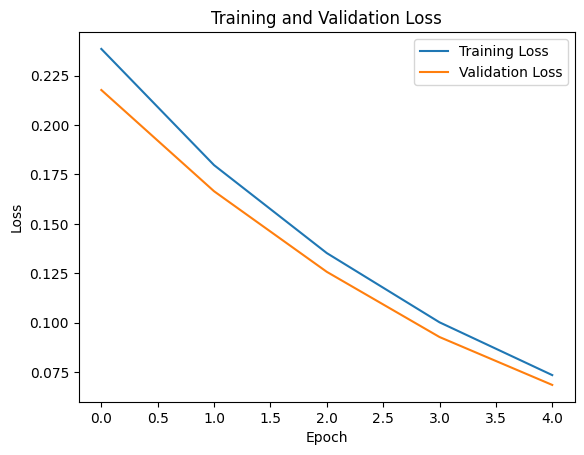

In [14]:
import matplotlib.pyplot as plt


# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming y_true contains the true target values and y_pred contains the predicted target values
predicted_temperature = regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predicted_temperature))
print("RMSE:", rmse)

50/50 [==============================] - 2s 6ms/step
RMSE: 0.24962936794930435


In [16]:
predicted_temperature = sc.inverse_transform(predicted_temperature)
y_test = sc.inverse_transform(y_test)

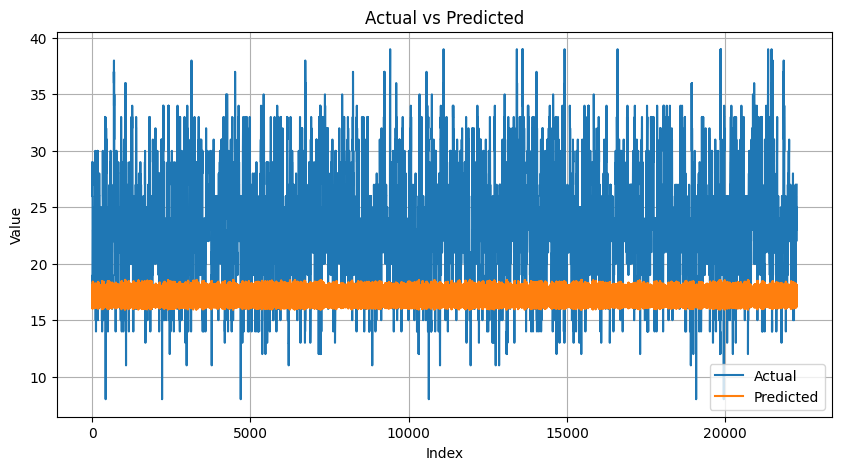

In [20]:
import matplotlib.pyplot as plt

# Assuming y_test contains the true target values and y_pred contains the predicted target values
plt.figure(figsize=(10, 5))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(predicted_temperature.flatten(), label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
accuracy_percentage = 100 * (1 - rmse/np.mean(y_test))
print(f"Accuracy: {accuracy_percentage:.2f}%")

Accuracy: 98.93%
